<a href="https://colab.research.google.com/github/86lekwenshiung/Graph-Network-for-Fraud-Analysis/blob/main/Network_Analysis_on_Enron_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Analysis with Enron Dataset
___

<p align="left">
  <img src="https://raw.githubusercontent.com/86lekwenshiung/Graph-Network-for-Fraud-Analysis/main/image/closeness_central_tim_receieve.PNG"/>


**Problem Statement**

The objective of this study is **primarily** to utilize Network Analysis to establish key personnel for the Enron Fraud and **secondarily**, using NLP on email content to attempt to establish the relation nature between the nodes.

**Model Explored**

|Technique|Description|
|---|---|
|Networkx|Basic Network exploration using Networkx Library|
|Email|Email library for extracting key information from email|
|Gephi|Program for Network Analysis|
|NLP|Using NLP Technique to format and extract information from emails|

**Evaluation Metrics**

`Since this is a network analysis , we will explore and determine key players from our network analysis by few of these centrality measures:.`
  * `Degree Centrality`
  * `Betweenness Centrality`
  * `Eigenvector Centrality`
  * `Closeness Centrality`
  * `PageRank`    


**Workflow Process**  
1. `Create API Token from Kaggle and Load into Colab`
2. `Preprocess the data`
    * `2.1  Using email library to split and extract key email header`
    * `2.2  Unpacking recipiant list with reference to sender`
    * `2.3  Understanding of dataset and story`

3. `Create Network Analysis`
  *  `3.1 Basic Exploration Using Networkx `
  *  `4.2 Exporting Dataset to Gephi`

4. `Interpreting key metrics on network model`
  * `Degree Centrality.`
  * `Betweenness Centrality`
  * `Eigen Centrality`
  * `Closeness Centrality`



# 0.0 Import Libraries
___


In [2]:
# Platform Interface
import os
import email
import requests
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Basic Libraries
import pandas as pd
import numpy as np
import random
import re
from itertools import chain
import datetime
pd.set_option('display.max_column' , None)
pd.set_option('display.max_rows',20)

# Network and Graph Related
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud

# ML Libraries
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize , sent_tokenize , RegexpTokenizer
from nltk.stem import PorterStemmer
stop_words = stopwords.words('english')
port_stemmer = PorterStemmer()
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer , TfidfVectorizer

plt.style.use('fivethirtyeight')
sns.set_style('white')

# !pip install kaggle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 0.5 General Function
___

In [4]:
def random_sentence_reader(df , col):
  sample_sentence = random.choice(df[col])

  return sample_sentence

In [5]:
def ngram_generator(df , ngram):
  
  """
  This function contains 2 actions in order to process the word into visualiation base on the ngram count.
  1. CountVectorize & Transform Data
  2. Convert Data back to Matrix
  """
  cvec = CountVectorizer(ngram_range=(ngram,ngram))
  cvec.fit(df['email'])
  transformed = cvec.transform(df['email'])

  df_transformed = pd.DataFrame(transformed.todense(),
                                columns = cvec.get_feature_names_out())
  
  return df_transformed

In [6]:
def ngram_visualizer(df1 , df2 , df3):


  fig , ax = plt.subplots(1 , 3 , figsize = (24,10))

  df1.sum().sort_values(ascending = True)[-20:].plot(kind = 'bar' , ax = ax[0])
  ax[0].set_title('Trending Words in All Subreddit Post' , fontsize = 14);

  df2.sum().sort_values(ascending = True)[-20:].plot(kind = 'bar' , ax = ax[1] , color = 'lightblue')
  ax[1].set_title('Trending Words in FAKENEWS Subreddit Post' , fontsize = 14);

  df3.sum().sort_values(ascending = True)[-20:].plot(kind = 'bar' , ax = ax[2] , color = 'green')
  ax[2].set_title('Trending Words in WORLDNEWS Subreddit Post' , fontsize = 14);

# 1.0 Data Preperation and EDA on Enron Dataset
___

* 1.1 [Load and Unzip Dataset Straight from Kaggle](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)
* 1.2.1 Cleaning Up Dataset Part 1
* 1.2.2 Cleaning Up Dataset Part 2
* 1.3 Unpacking Recipiant and Sender into single entity
* 1.4 Going in depth into Dataset

### 1.1 Load and Unzip Dataset Straight from Kaggle
___

In [15]:
# Step 1 of 4 : Make a directory named “.kaggle”
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [16]:
# Step 2 of 4 : Copy the “kaggle.json” into this new directory
# Ensure kaggle.json is first created beforehand and uploaded into Session Storage
! cp kaggle.json ~/.kaggle/

In [17]:
# Step 3 of 4 :  Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

In [20]:
# Step 4 of 4 
! kaggle datasets download wcukierski/enron-email-dataset

 99% 353M/358M [00:05<00:00, 77.7MB/s]
100% 358M/358M [00:05<00:00, 66.0MB/s]


In [22]:
! unzip '/content/enron-email-dataset.zip'

Archive:  /content/enron-email-dataset.zip
  inflating: emails.csv              


### 1.2.1 Cleaning Up Dataset Part 1
___

* Credit and Source from https://www.kaggle.com/keeperboy/enron-email-analysis-link-analysis for the cleaning up in this section 1.2

In [23]:
# enron_email_path  = '/content/gdrive/MyDrive/Graph Network for Fraud Analysis/data/emails.csv'

enron_email_path = "/content/emails.csv"
df_email = pd.read_csv(enron_email_path)

In [24]:
df_email.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [25]:
# Sample Enron Email
sample_message = random.choice(df_email['message'])
sample_message

'Message-ID: <18514276.1075852145960.JavaMail.evans@thyme>\nDate: Mon, 22 Oct 2001 08:38:28 -0700 (PDT)\nFrom: pete.davis@enron.com\nTo: pete.davis@enron.com\nSubject: Start Date: 10/22/01; HourAhead hour: 11;  <CODESITE>\nCc: bert.meyers@enron.com, bill.williams@enron.com, craig.dean@enron.com, \n\teric.linder@enron.com, geir.solberg@enron.com, kate.symes@enron.com, \n\tleaf.harasin@enron.com, mark.guzman@enron.com, pete.davis@enron.com, \n\tryan.slinger@enron.com\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nBcc: bert.meyers@enron.com, bill.williams@enron.com, craig.dean@enron.com, \n\teric.linder@enron.com, geir.solberg@enron.com, kate.symes@enron.com, \n\tleaf.harasin@enron.com, mark.guzman@enron.com, pete.davis@enron.com, \n\tryan.slinger@enron.com\nX-From: Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PDAVIS1>\nX-To: Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PDAVIS1>\nX-cc: Meyers, Bert </O=ENRON/OU=NA/CN=RECIPIENTS/CN=BMEYERS>

In [26]:
# Sample Enrol Email Split by newline
sample_message_split = sample_message.split('\n')
sample_message_split

['Message-ID: <18514276.1075852145960.JavaMail.evans@thyme>',
 'Date: Mon, 22 Oct 2001 08:38:28 -0700 (PDT)',
 'From: pete.davis@enron.com',
 'To: pete.davis@enron.com',
 'Subject: Start Date: 10/22/01; HourAhead hour: 11;  <CODESITE>',
 'Cc: bert.meyers@enron.com, bill.williams@enron.com, craig.dean@enron.com, ',
 '\teric.linder@enron.com, geir.solberg@enron.com, kate.symes@enron.com, ',
 '\tleaf.harasin@enron.com, mark.guzman@enron.com, pete.davis@enron.com, ',
 '\tryan.slinger@enron.com',
 'Mime-Version: 1.0',
 'Content-Type: text/plain; charset=us-ascii',
 'Content-Transfer-Encoding: 7bit',
 'Bcc: bert.meyers@enron.com, bill.williams@enron.com, craig.dean@enron.com, ',
 '\teric.linder@enron.com, geir.solberg@enron.com, kate.symes@enron.com, ',
 '\tleaf.harasin@enron.com, mark.guzman@enron.com, pete.davis@enron.com, ',
 '\tryan.slinger@enron.com',
 'X-From: Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PDAVIS1>',
 'X-To: Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PDAVIS1>',
 'X-cc:

In [27]:
print('Sample Date Extract: ' , sample_message.split('\n')[1])
print('Sample Sender: ' , sample_message.split('\n')[2])
print('Sample Receipant: ' , sample_message.split('\n')[3])
print('Sample Subject: ' , sample_message.split('\n')[4])
print('Sample cc: ' , sample_message.split('\n')[5])
print('Sample bcc: ' , sample_message.split('\n')[9])

Sample Date Extract:  Date: Mon, 22 Oct 2001 08:38:28 -0700 (PDT)
Sample Sender:  From: pete.davis@enron.com
Sample Receipant:  To: pete.davis@enron.com
Sample Subject:  Subject: Start Date: 10/22/01; HourAhead hour: 11;  <CODESITE>
Sample cc:  Cc: bert.meyers@enron.com, bill.williams@enron.com, craig.dean@enron.com, 
Sample bcc:  Mime-Version: 1.0


In [29]:
# Using Email library to read sample Email

x = df_email.loc[10000]['message']
email.message_from_string(x).items()

[('Message-ID', '<7929445.1075854731596.JavaMail.evans@thyme>'),
 ('Date', 'Fri, 21 Jan 2000 09:15:00 -0800 (PST)'),
 ('From', 'eric.bass@enron.com'),
 ('To', 'kyle.lilly@enron.com'),
 ('Subject', 'New Model'),
 ('Cc', 'joanie.ngo@enron.com'),
 ('Mime-Version', '1.0'),
 ('Content-Type', 'text/plain; charset=us-ascii'),
 ('Content-Transfer-Encoding', '7bit'),
 ('Bcc', 'joanie.ngo@enron.com'),
 ('X-From', 'Eric Bass'),
 ('X-To', 'Kyle R Lilly'),
 ('X-cc', 'Joanie H Ngo'),
 ('X-bcc', ''),
 ('X-Folder', "\\Eric_Bass_Dec2000\\Notes Folders\\'sent mail"),
 ('X-Origin', 'Bass-E'),
 ('X-FileName', 'ebass.nsf')]

In [31]:
# 1st round of Extraction
df_email['date'] = df_email['message'].apply(lambda x: email.message_from_string(x).get('Date'))
df_email['subject'] = df_email['message'].apply(lambda x: email.message_from_string(x).get('Subject'))
df_email['sender_email'] = df_email['message'].apply(lambda x: email.message_from_string(x).get('From'))
df_email['recipient_email'] = df_email['message'].apply(lambda x: email.message_from_string(x).get('To'))
df_email['cc'] = df_email['message'].apply(lambda x: email.message_from_string(x).get('Cc'))
df_email['bcc'] = df_email['message'].apply(lambda x: email.message_from_string(x).get('Bcc'))
df_email["body"] = df_email['message'].apply(lambda x: email.message_from_string(x).get_payload())

# 2nd Round of Extraction
df_email['date'] = pd.to_datetime(df_email['date'] , utc = True)
df_email["day_of_week"] = df_email['date'].dt.day_name()
df_email['date'] = df_email['date'].dt.strftime('%Y-%m-%d')

In [32]:
print('email DF after cleaned :' , df_email.shape)
df_email.head()

email DF after cleaned : (517401, 10)


,file,message,date,subject,sender_email,recipient_email,cc,bcc,body,day_of_week
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,2001-05-14,,phillip.allen@enron.com,tim.belden@enron.com,None,None,Here is our forecast\n\n,Monday
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,2001-05-04,Re:,phillip.allen@enron.com,john.lavorato@enron.com,None,None,Traveling to have a business meeting takes the...,Friday
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,2000-10-18,Re: test,phillip.allen@enron.com,leah.arsdall@enron.com,None,None,test successful. way to go!!!,Wednesday
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,2000-10-23,,phillip.allen@enron.com,randall.gay@enron.com,None,None,"Randy,\n\n Can you send me a schedule of the s...",Monday
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,2000-08-31,Re: Hello,phillip.allen@enron.com,greg.piper@enron.com,None,None,Let's shoot for Tuesday at 11:45.,Thursday


In [33]:
#Exporting to Google Drive Since the first cleaning take some time
enron_email_path  = '/content/gdrive/MyDrive/Graph Network for Fraud Analysis/data/emails_cleaned.csv'

df_email.to_csv(enron_email_path)

### 1.2.2 Cleaning Up Dataset Part 2
___

In [7]:
# Clean Up Round #2
enron_email_path  = '/content/gdrive/MyDrive/Graph Network for Fraud Analysis/data/emails_cleaned.csv'

df_email = pd.read_csv(enron_email_path , parse_dates = ['date'])

In [8]:
df_email.fillna('' , inplace = True)

# Removing Email that has no recipant
print('Before Excluding no Recipient' , df_email.shape)
df_email = df_email[df_email['recipient_email'] != '']
print('After Excluding no Recipient' , df_email.shape)

# Combining Total Recipiants
df_email['recipient_email'] = df_email['recipient_email'].apply(lambda x : x.replace('\n\t' , ''))
df_email['cc'] = df_email['cc'].apply(lambda x : x.replace('\n\t' , ''))
df_email['bcc'] = df_email['bcc'].apply(lambda x : x.replace('\n\t' , ''))

df_email["all_recipient_emails"] = df_email[['recipient_email' , 'cc' , 'bcc']].apply(pd.unique,1).apply(','.join).str.rstrip(',')
df_email["num_recipient"] = df_email['all_recipient_emails'].apply(lambda x : len(x.split(',')))

Before Excluding no Recipient (517401, 11)
After Excluding no Recipient (495554, 11)


In [9]:
# Filtering Email from 1985 to 2002
df_email["year"] = df_email['date'].dt.year

print('Before Excluding Out of Range Year' , df_email.shape)
df_email = df_email[(df_email['year'] >1984) & (df_email['year'] <2003)]
print('After Excluding Out of Range Year' , df_email.shape)


Before Excluding Out of Range Year (495554, 14)
After Excluding Out of Range Year (495160, 14)


In [10]:
df_email.head()

,Unnamed: 0,file,message,date,subject,sender_email,recipient_email,cc,bcc,body,day_of_week,all_recipient_emails,num_recipient,year
0,0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,2001-05-14,,phillip.allen@enron.com,tim.belden@enron.com,,,Here is our forecast\n\n,Monday,tim.belden@enron.com,1,2001
1,1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,2001-05-04,Re:,phillip.allen@enron.com,john.lavorato@enron.com,,,Traveling to have a business meeting takes the...,Friday,john.lavorato@enron.com,1,2001
2,2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,2000-10-18,Re: test,phillip.allen@enron.com,leah.arsdall@enron.com,,,test successful. way to go!!!,Wednesday,leah.arsdall@enron.com,1,2000
3,3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,2000-10-23,,phillip.allen@enron.com,randall.gay@enron.com,,,"Randy,\n\n Can you send me a schedule of the s...",Monday,randall.gay@enron.com,1,2000
4,4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,2000-08-31,Re: Hello,phillip.allen@enron.com,greg.piper@enron.com,,,Let's shoot for Tuesday at 11:45.,Thursday,greg.piper@enron.com,1,2000


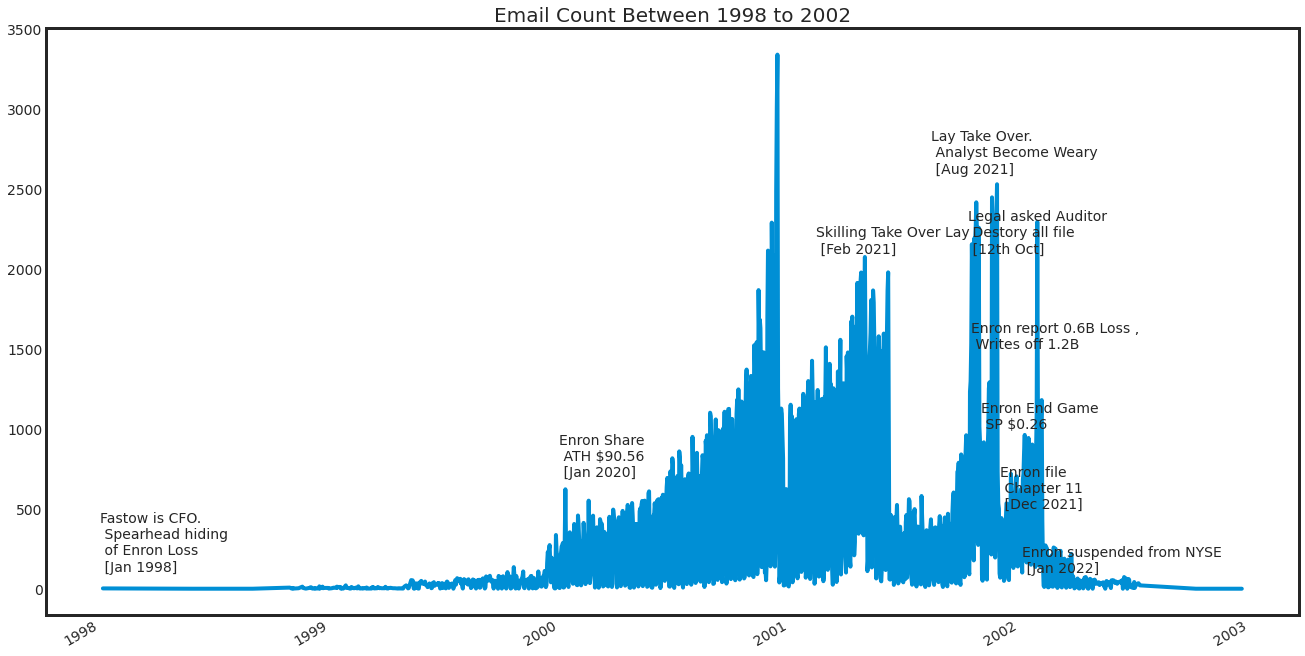

In [11]:
df_email['date'].value_counts().sort_index()[4:].plot(kind = 'line' , figsize = (20,12));

plt.title('Email Count Between 1998 to 2002' , fontsize = 20)

plt.text(x = '1998-01-01' , y = 110, s = 'Fastow is CFO. \n Spearhead hiding \n of Enron Loss \n [Jan 1998]')

plt.text(x = '2000-01-01' , y = 700, s = 'Enron Share \n ATH $90.56 \n [Jan 2020]');
plt.text(x = '2001-02-12' , y = 2100, s = 'Skilling Take Over Lay \n [Feb 2021]');
plt.text(x = '2001-08-14' , y = 2600, s = 'Lay Take Over. \n Analyst Become Weary \n [Aug 2021]');
plt.text(x = '2001-10-12' , y = 2100, s = 'Legal asked Auditor \n Destory all file \n [12th Oct]');
plt.text(x = '2001-10-16' , y = 1500, s = 'Enron report 0.6B Loss , \n Writes off 1.2B');
plt.text(x = '2001-11-01' , y = 1000, s = 'Enron End Game \n SP $0.26');
plt.text(x = '2001-12-02' , y = 500, s = 'Enron file \n Chapter 11 \n [Dec 2021]');
plt.text(x = '2002-01-05' , y = 100, s = 'Enron suspended from NYSE \n [Jan 2022]');

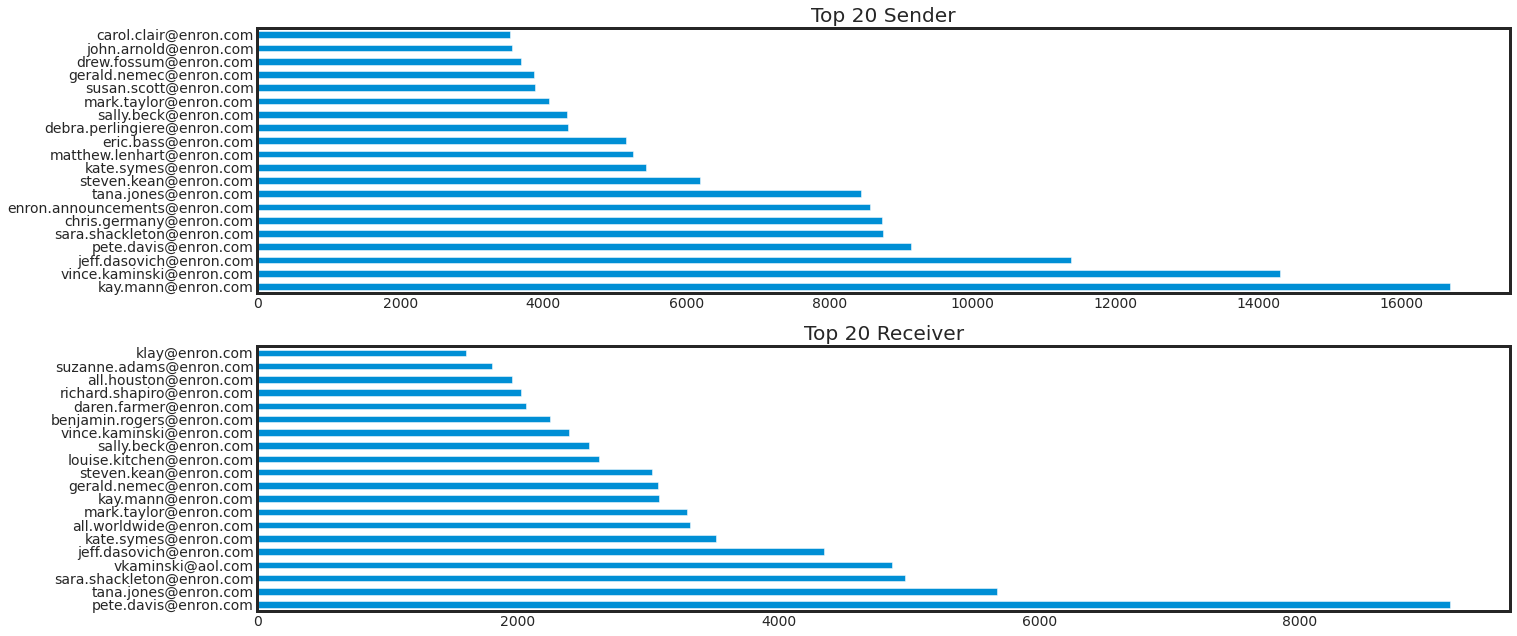

In [12]:
fig , axes = plt.subplots(2,1,figsize = (20,10))

df_email['sender_email'].value_counts()[:20].plot(kind = 'barh' , ax = axes[0])
df_email['recipient_email'].value_counts()[:20].plot(kind = 'barh' , ax = axes[1]);

axes[0].set_title('Top 20 Sender')
axes[1].set_title('Top 20 Receiver');

In [13]:
def extract_entity(text):	

    list_of_emails = re.findall(r"@[\w]+", text)
    result = []
    for item in list_of_emails:		
        result.append(item[1:])

    return set(result)

In [14]:
#- extract sender and recipient entity info
df_email["sender_entity"]    = df_email.loc[:,"sender_email"].apply(lambda x : extract_entity(x))
df_email["recipient_entity_to"] = df_email.loc[:,"recipient_email"].apply(lambda x : extract_entity(x))
df_email["recipient_entity_cc"] = df_email.loc[:,"cc" ].apply(lambda x : extract_entity(x))
df_email["recipient_entity_bcc"] = df_email.loc[:,"bcc"].apply(lambda x : extract_entity(x))
df_email["all_recipient_entities"] = df_email.apply(lambda x : \
                                                 x["recipient_entity_to" ] | \
                                                 x["recipient_entity_cc" ] | \
                                                 x["recipient_entity_bcc"], axis = 1)

df_email["sender_entity"] = df_email.sender_entity.apply(lambda x : list(x))
df_email["all_recipient_entities"] = df_email.all_recipient_entities.apply(lambda x : list(x))

# #- extract subject
# df_email.loc[:,"subject"] = df_email.loc[:,"subject"].apply(lambda x : extract_subject(x))

#=== select and reorder the colums
df = df_email.loc[:,["date","day_of_week","subject","body","sender_email","all_recipient_emails",
                                 "sender_entity","all_recipient_entities","num_recipient"]]  

df.reset_index(inplace = True)

In [15]:
print('df_email shape :' , df_email.shape)
print('df shape :' , df.shape)
df.loc[202205 : 202208]

df_email shape : (495160, 19)
df shape : (495160, 10)


,index,date,day_of_week,subject,body,sender_email,all_recipient_emails,sender_entity,all_recipient_entities,num_recipient
202205,210535,2001-04-11,Wednesday,Re: CHARM,"Jim,\n\nCHARM looks more like a prototype tha...",vince.kaminski@enron.com,"james.bouillion@enron.com,vince.kaminski@enron...",[enron],[enron],3
202206,210536,2000-11-06,Monday,Re: Avistar Training,I will keep you informed !\n------------------...,kevin.moore@enron.com,"vince.kaminski@enron.com, mike.roberts@enron.c...",[enron],[enron],4
202207,210537,2000-11-06,Monday,Re: Meeting Tuesday,"Dale,\n\nYour memory did not fail you.\nWe wou...",vince.kaminski@enron.com,"dale.nesbitt@worldnet.att.net,vince.kaminski@e...",[enron],"[worldnet, enron]",2
202208,210538,2000-11-03,Friday,Confirmation of your order,This is an automatic confirmation of the order...,messaging.agent@enron.com,"leann.walton@enron.com,vince.kaminski@enron.com",[enron],[enron],2


### 1.3 Unpacking Sender and Receipant
___

In [16]:
def unpack_str(df_col1, df_col2):
    result_df = pd.DataFrame({ "send" : np.repeat(df_col1.values, df_col2.str.count(',') + 1),
                               "receive": list(chain.from_iterable(df_col2.str.split(',')))})
    return result_df

def unpack_list(df_col1, df_col2):
    result_df = pd.DataFrame({ "send" : np.repeat(df_col1.values, df_col2.str.len()),
                               "receive": list(chain.from_iterable(df_col2))})
    return result_df      

In [17]:
df2a = unpack_str(df['sender_email'], df['all_recipient_emails'])
df2b = unpack_list(df['sender_entity'], df['all_recipient_entities'])

# df2b_senderlist = df2b['send'][:400000].apply(lambda x : x[0]).to_list().extend(df2b['send'][400000 : df2b.shape[0]].apply(lambda x : x[0]).to_list())

print('df2a :' , df2a.shape)
print('df2b :' , df2b.shape)

df2a : (3685225, 2)
df2b : (762200, 2)


In [18]:
df2a.head()

,send,receive
0,phillip.allen@enron.com,tim.belden@enron.com
1,phillip.allen@enron.com,john.lavorato@enron.com
2,phillip.allen@enron.com,leah.arsdall@enron.com
3,phillip.allen@enron.com,randall.gay@enron.com
4,phillip.allen@enron.com,greg.piper@enron.com


### 1.4 Going in depth on the dataset
___

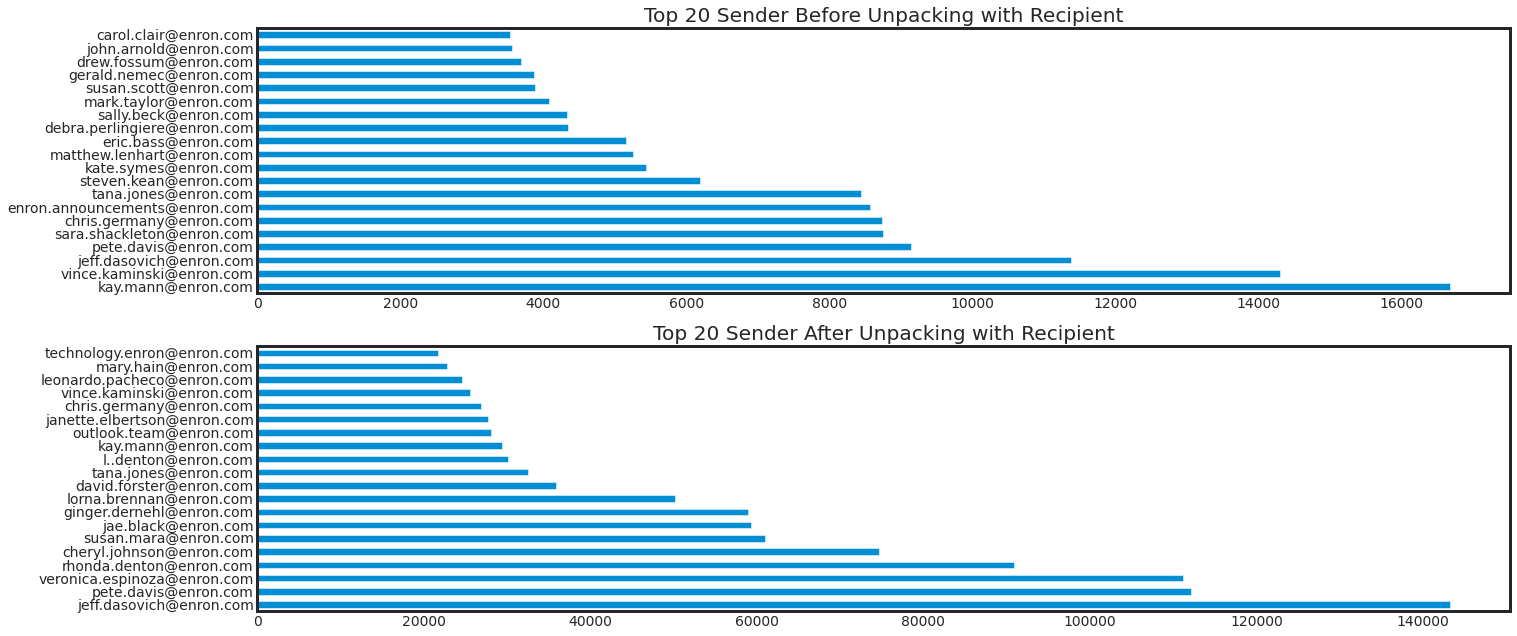

In [19]:
fig , axes = plt.subplots(2,1,figsize = (20,10))

df_email['sender_email'].value_counts()[:20].plot(kind = 'barh' , ax = axes[0])
df2a['send'].value_counts()[:20].plot(kind = 'barh' , ax = axes[1]);

axes[0].set_title('Top 20 Sender Before Unpacking with Recipient')
axes[1].set_title('Top 20 Sender After Unpacking with Recipient');

# 2.0 Network Analysis By Networkx Library
___

* 2.1 Filtering out Top nodes for analysis
* 2.2 Getting Centrality Value
* 2.3 Doing Basic Network Plot with Networkx

| Type of Centrality 	| Description 	|
|---	|---	|
| Degree Centrality 	| It’s the most intuitive notion of centrality. Node with the highest degree is the most important. <br>It gives the index of exposure to what is flowing in the network. Central actor is most likely to hear a gossip 	|
| Betweenness Centrality 	| Betweenness centrality of a node ‘u’ is the ratio of the shortest paths between all other nodes that pass through u. 	|
| Eigenvector Centrality 	| It’s the measure of influence of a node in a network. Connections to high scoring nodes contribute more. <br>“An important node is connected to important neighbor” which means a node has high score if connected to many nodes are themselves well connected. <br>Power iteration is one of the eigenvector algorithm 	|
| Closeness Centrality 	| A node is considered important if it is relatively close to all other nodes. <br>It’s a measure of how long it will take to spread info from node 'u' to all other nodes 	||

### 2.1 Filtering out Top Nodes with high degree
___

In [20]:
G1 = nx.from_pandas_edgelist(df2a, "send", "receive")
G1.remove_edges_from(nx.selfloop_edges(G1))

print('No of Nodes in whole dataset :' , G1.number_of_nodes())

No of Nodes in whole dataset : 100164


In [21]:
# Zooming into top 1000 nodes (1% of total Nodes)
G1000 = nx.k_core(G1, 40) 
G1000.number_of_nodes()

print('No of Nodes in filtered network :' , G1000.number_of_nodes())

No of Nodes in filtered network : 1087


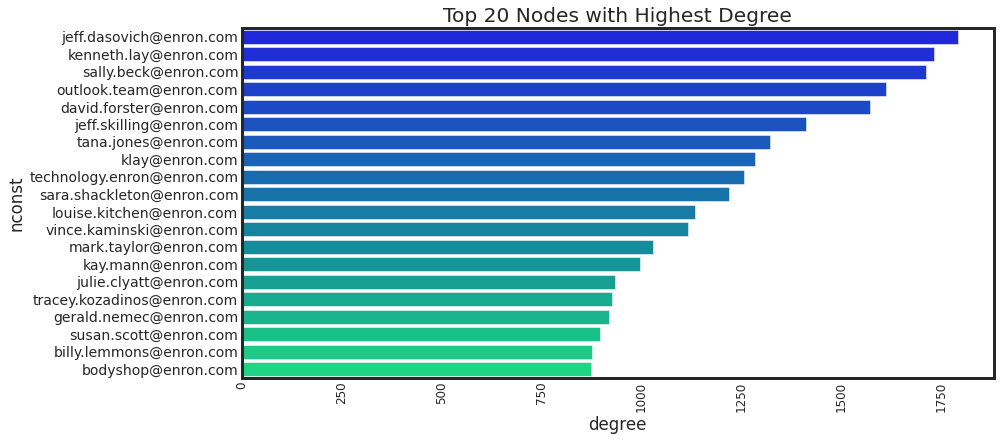

In [22]:
G1_degree = pd.DataFrame(sorted(G1.degree, key=lambda x: x[1], reverse=True))
G1_degree.columns = ['nconst','degree']

plt.figure(figsize = (12,6))
sns.barplot(y = 'nconst',
            x = 'degree',
            data = G1_degree[:20],
            palette = 'winter')
plt.xticks(rotation = 90 , fontsize = 12)
plt.title('Top 20 Nodes with Highest Degree');

In [23]:
# known_guilty = ["kenneth.lay@enron.com", "jeff.skilling@enron.com",
#     "andrew.fastow@enron.com", "richard.causey@enron.com",
#     "michael.kopper@enron.com", "smiley@flash.net", "ben.glisan@enron.com",
#     "greg.whalley@enron.com", "mark.koenig@enron.com", "lou.pai@enron.com",
#     "ken.rice@enron.com", "rebecca.mark@enron.com"]

### 2.2 Getting Centrality value
___

* Betweenness centrality measures the number of times a node lies on the shortest path between other nodes.
  * **What it tells us**: This measure shows which nodes are ‘bridges’ between nodes in a network. It does this by identifying all the shortest paths and then counting how many times each node falls on one.
  * **When to use it**: For finding the individuals who influence the flow around a system.


* Degree centrality assigns an importance score based simply on the number of links held by each node.

  * **What it tells us**: How many direct, ‘one hop’ connections each node has to other nodes in the network.
  * **When to use it**: For finding very connected individuals, popular individuals, individuals who are likely to hold most information or individuals who can quickly connect with the wider network.

* Closeness centrality scores each node based on their ‘closeness’ to all other nodes in the network.
  * **What it tells us**: This measure calculates the shortest paths between all nodes, then assigns each node a score based on its sum of shortest paths.
  * **When to use it**: For finding the individuals who are best placed to influence the entire network most quickly.

* EigenCentrality measures a node’s influence. It starts by measuring each nodes ‘degree’ score – which is simply a count of the number of links that node has to other nodes in the network. However, EigenCentrality goes a step further than degree centrality. It goes beyond the first-degree connections to count how many links their connections have, and so on through the network.

In [24]:
closeness_G1000 = nx.closeness_centrality(G1000)
eigen_G1000 = nx.eigenvector_centrality(G1000)
between_G1000 = nx.betweenness_centrality(G1000)
degree_G1000 = nx.degree_centrality(G1000)

In [25]:
def centrality_metric(metrics , name):
  df = pd.DataFrame({'email' : list(metrics.keys()),
                     'closeness' : list(metrics.values())
                    })
  df = df.sort_values(by = 'closeness' , ascending = False)
  df['weighted_' + name] = df['closeness'] / max(df['closeness'])

  return df

In [26]:
df_closeness = centrality_metric(closeness_G1000 , 'close')
df_eigen = centrality_metric(eigen_G1000 , 'eigen')
df_between = centrality_metric(between_G1000 , 'between')
df_degree = centrality_metric(degree_G1000 , 'degree')

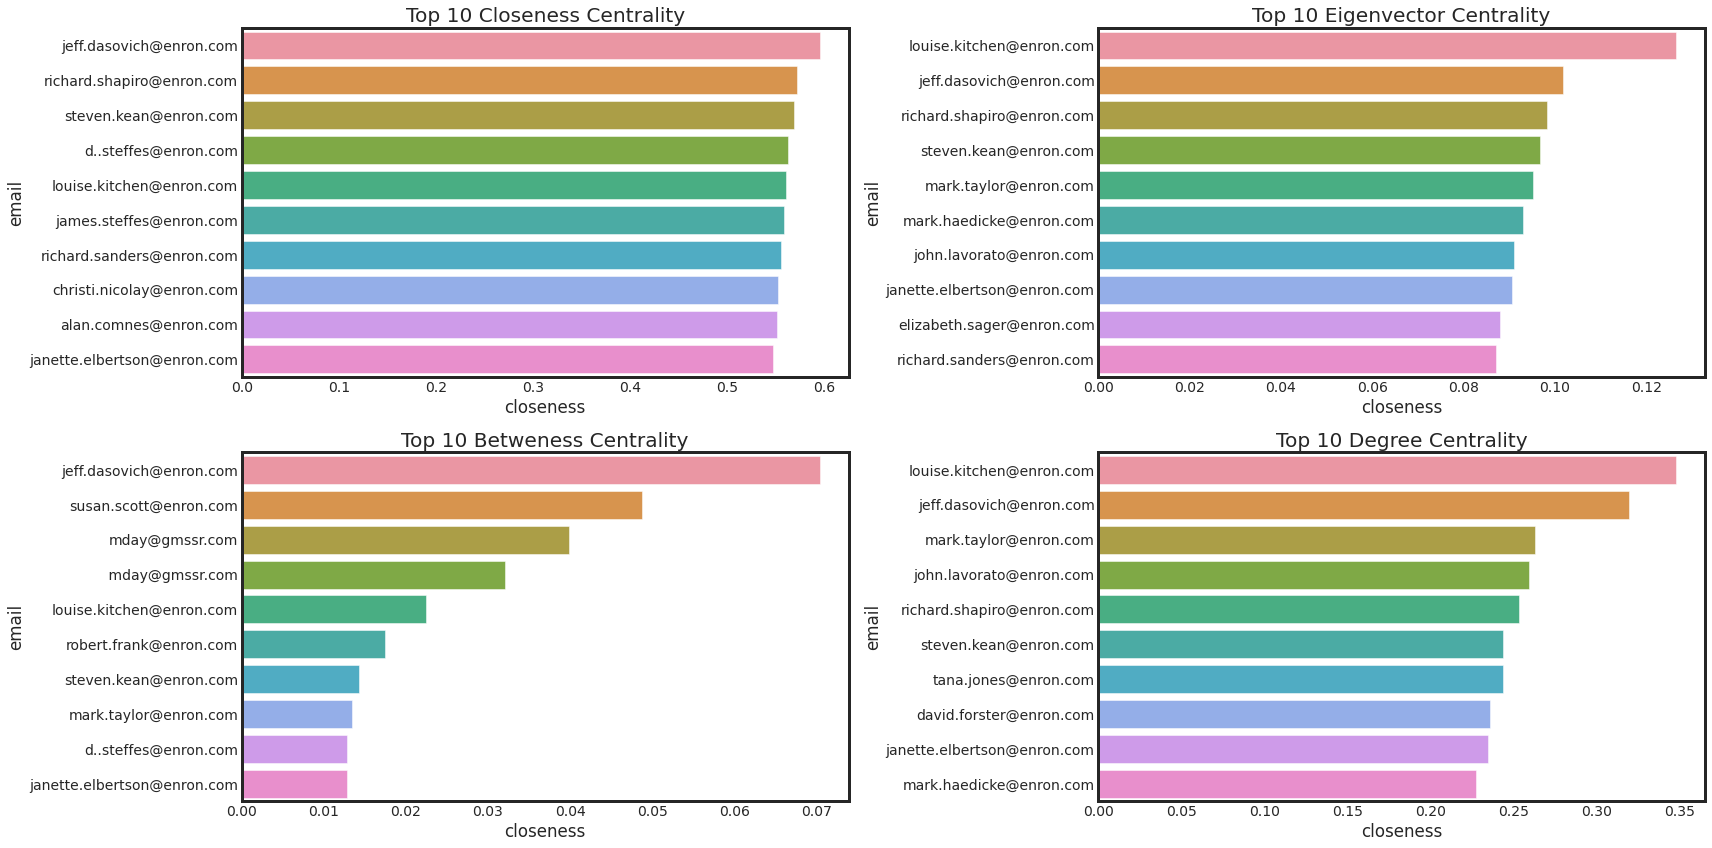

In [27]:
fig , ax = plt.subplots(2,2 , figsize = (24,12))

ax = ax.ravel()

sns.barplot(y = 'email' , x = 'closeness' , data = df_closeness[:10] , ax = ax[0])
sns.barplot(y = 'email' , x = 'closeness' , data = df_eigen[:10] , ax = ax[1])
sns.barplot(y = 'email' , x = 'closeness' , data = df_between[:10] , ax = ax[2])
sns.barplot(y = 'email' , x = 'closeness' , data = df_degree[:10] , ax = ax[3])

ax[0].set_title('Top 10 Closeness Centrality')
ax[1].set_title('Top 10 Eigenvector Centrality')
ax[2].set_title('Top 10 Betweness Centrality')
ax[3].set_title('Top 10 Degree Centrality')

plt.tight_layout()

### 2.3 Visualing Network Plot
___

#### 2.3.1 Random Visualising 3000 data rows from whole network
- Even with 3000 sample rows , network visualisation is very cluttered and not very meaningful
- It is very static and not friendly for deep diving.

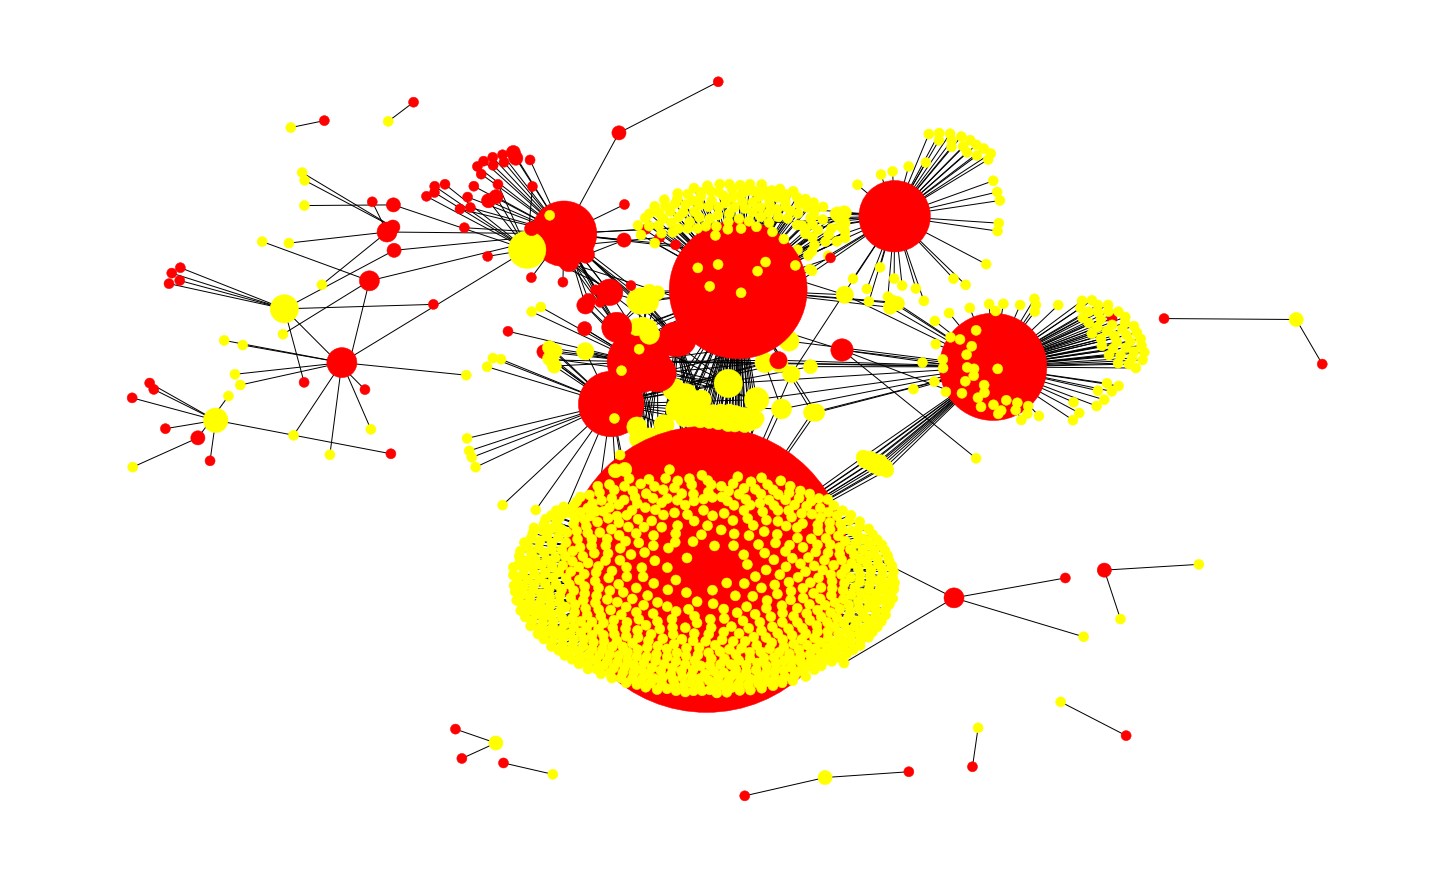

In [28]:
plt.figure(figsize = (20,12))

G1 = nx.from_pandas_edgelist(df2a[10000:13000], "send", "receive")
G1.remove_edges_from(nx.selfloop_edges(G1))

# Defining Color of Col
# Send = red , receieve = yellow
colors = []
for node in G1:
  if node in df2a['send'].values:
    colors.append('red')
  else:
    colors.append('yellow')

pos1 = nx.spring_layout(G1, k=.1)

# Creating node size and width
node_size = [v * 100 for v in dict(G1.degree()).values()]

nx.draw(G1 , 
        pos = pos1,
        with_labels = False , 
        node_color = colors,
        node_size = node_size)

#### 2.3.2 Visualising nodes with on top 1000 nodes (1%)
___

- Even using only 1% of the nodes (1087) compared to the total nodes(~100,000) , it is still very cluttered as expected.

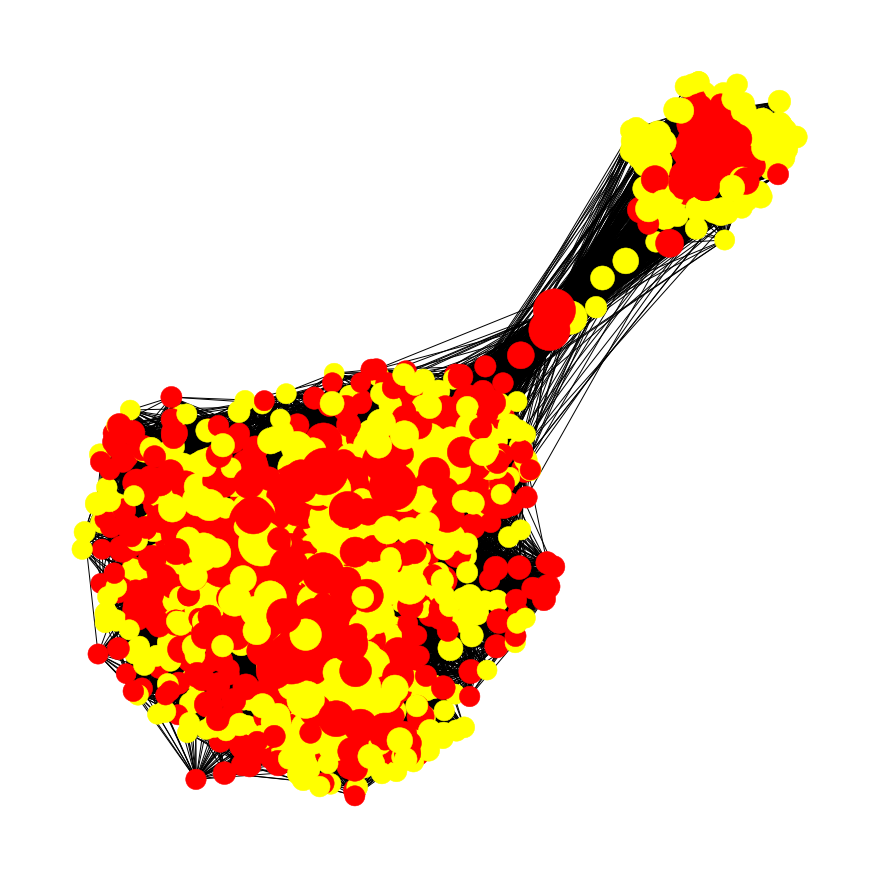

In [29]:
plt.figure(figsize = (12,12))

# Defining Color of Col
# Send = red , receieve = yellow
colors = []
for node in G1000:
  if node in df2a['send'].values:
    colors.append('red')
  else:
    colors.append('yellow')

pos1 = nx.spring_layout(G1000, k=.1)

# Creating node size and width
node_size = [v * 10 for v in dict(G1000.degree()).values()]

nx.draw(G1000 , 
        with_labels = False , 
        node_color = colors,
        node_size = node_size)

# 3.0 Network Analysis By Gephi
___

- Gephi is very particular about the column header for nodes and edges when importing csv.
- Nodes required a Id and Label header.
- Edges required Source and Target Header.
- Total Nodes Studied : 1087
- Total Edges Studied : 41711

### 3.1 Prepare and Export Data to CSV
___

In [30]:
df_G1000 = pd.DataFrame(sorted(G1000.degree, key=lambda x: x[1], reverse=True))
df_G1000.columns = ['label' , 'degree']
df_G1000.head()

,label,degree
0,louise.kitchen@enron.com,378
1,jeff.dasovich@enron.com,347
2,mark.taylor@enron.com,286
3,john.lavorato@enron.com,282
4,richard.shapiro@enron.com,275


In [31]:
label_code = df_G1000['label'].astype('category').cat.codes + 1
df_G1000['Id'] = label_code

df_G1000.sort_values(by = 'Id' , inplace = True)
df_G1000.set_index('Id' , inplace = True)


label_dict = dict(zip(df_G1000['label'] ,label_code))

In [32]:
df_edges = nx.to_pandas_edgelist(G1000)
print('DF edges shape:' ,df_edges.shape)
df_edges.head()

DF edges shape: (41771, 2)


,source,target
0,nony.flores@enron.com,susan.bailey@enron.com
1,nony.flores@enron.com,alan.aronowitz@enron.com
2,nony.flores@enron.com,michelle.cash@enron.com
3,nony.flores@enron.com,barbara.gray@enron.com
4,nony.flores@enron.com,jeffrey.hodge@enron.com


In [33]:
df_edges['source'] = df_edges['source'].map(label_dict)
df_edges['target'] = df_edges['target'].map(label_dict)

In [34]:
df_edges.to_csv("edges.csv" , index = False)
df_G1000.to_csv("nodes.csv" , index_label = 'Id')

### 3.2 Comparing Visualisation with Networkx
___

- We used the 2 exported csv and uploaded into Gephi.
- The General overview without filtering are observed to be quite similiar with 
2 obvious communities.

|Property|Value|
|---|---|
|Total Nodes|1087|
|Total Edges|41711|
|Highest Degree|378|
|Lowest Degree|40|

<p align="center">
  <img src="https://raw.githubusercontent.com/86lekwenshiung/Graph-Network-for-Fraud-Analysis/main/image/networkx_gephi.png" />
</p>

### 3.3 Partition into Communities
___

- Using Gephi , we run modularity classes to create communities.
- Depending on the resolutions , Gephi is able to generate the required communities.
<p align="center">
  <img src="https://raw.githubusercontent.com/86lekwenshiung/Graph-Network-for-Fraud-Analysis/main/image/partition.PNG" />
</p>

In [35]:
# Alternatively we could also create community from the networkx library
from community import community_louvain
partition = community_louvain.best_partition(G1000)
#Turn partition into dataframe
partition1 = pd.DataFrame([partition]).T
partition1 = partition1.reset_index()
partition1.columns = ['names','group']

In [36]:
# By default , we have 5 communities created ; same as what Gephi would have created by default
partition1['group'].unique()

array([0, 1, 2, 3, 4])

In [37]:
G_sorted = pd.DataFrame(sorted(G1000.degree, key=lambda x: x[1], reverse=True))
G_sorted.columns = ['names','degree']
G_sorted.head()
dc = G_sorted

combined = pd.merge(dc,partition1, how='left', left_on="names",right_on="names")
combined.head()

,names,degree,group
0,louise.kitchen@enron.com,378,2
1,jeff.dasovich@enron.com,347,3
2,mark.taylor@enron.com,286,0
3,john.lavorato@enron.com,282,2
4,richard.shapiro@enron.com,275,3


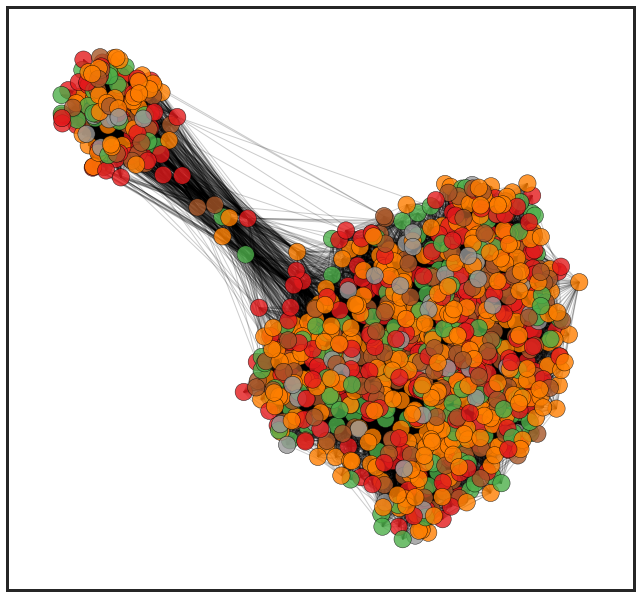

In [38]:
# We set the color of the node base on the group created

pos = nx.spring_layout(G1000)
f, ax = plt.subplots(figsize=(10, 10))

nodes = nx.draw_networkx_nodes(G1000, pos,
                               cmap=plt.cm.Set1,
                               node_color=combined['group'],
                               alpha=0.8)
nodes.set_edgecolor('k')
# nx.draw_networkx_labels(G_tmp, pos, font_size=8)
nx.draw_networkx_edges(G1000, pos, width=1.0, alpha=0.2);

### 3.4 Deep Diving into how we can utilise Network Analysis for investigation
___

* From documentaries such as The Smartest Guy in the Room , we are aware that **Timothy Belden** is one of the key trader involved in this scandal. He is considered the mastermind of Enron Corp.'s scheme to drive up California's energy prices, pleaded guilty Thursday to a federal conspiracy charge.

* Without even having read the emails, we managed to establish who belonged in Belden’s first circle inside Enron and established that some people in his network knew each other as well. It turned out that Belden, Lavorato and Presto indeed knew about project Stanley and were all potentially involved in it. Linkurious is the perfect tool to investigate social networks in detail, find key people and communities, establish responsibilities and relationships. Linkurious can be used to conduct large-scale audits or investigation inside large organisations of any kind.

In [39]:
# Checking top reciever from Timothy
df_temp = df2a[df2a['send'] == 'tim.belden@enron.com']
df_temp.groupby('receive').count().sort_values(by = 'send' , ascending = False)[:10]

,send
receive,
center.dl-portland@enron.com,101
jeff.richter@enron.com,93
sean.crandall@enron.com,86
mark.fischer@enron.com,86
robert.badeer@enron.com,80
diana.scholtes@enron.com,76
tom.alonso@enron.com,75
tim.belden@enron.com,66
tim.heizenrader@enron.com,66


In [40]:
# Checking top rsender to Timothy
df_temp = df2a[df2a['receive'] == 'tim.belden@enron.com']
df_temp.groupby('send').count().sort_values(by = 'receive' , ascending = False)[:10]

,receive
send,
rhonda.denton@enron.com,498
carla.hoffman@enron.com,159
john.lavorato@enron.com,78
ray.alvarez@enron.com,77
david.delainey@enron.com,71
alan.comnes@enron.com,69
mary.hain@enron.com,66
kay.chapman@enron.com,63
jeff.dasovich@enron.com,59


#### 3.4.1 Betweenness Centrality
___

* Betweenness centrality measures the number of times a node lies on the shortest path between other nodes.
  * **What it tells us**: This measure shows which nodes are ‘bridges’ between nodes in a network. It does this by identifying all the shortest paths and then counting how many times each node falls on one.
  * **When to use it**: For finding the individuals who influence the flow around a system.

* Although Timothy Belden had a very small node size in betweenness centrality , we could observed that it has very short distance to major nodes with high betweenness.
* Timothy also appear to be very active across the various communities.

<p align="center">

  <img src="https://raw.githubusercontent.com/86lekwenshiung/Graph-Network-for-Fraud-Analysis/main/image/between_central_tim_receieve.PNG" width = 80%/> 
  
  Above Image : Betwenness Centrality for Timothy (Target Node)

  <img src="https://raw.githubusercontent.com/86lekwenshiung/Graph-Network-for-Fraud-Analysis/main/image/between_central_tim_send.PNG" width = 80%/>
  Above Image : Betwenness Centrality for Timothy (Source Node)
</p>


#### 3.4.2 Eiganvector Centrality
___

* Eigenvector Centrality measures the transitive influence of nodes. Relationships originating from high-scoring nodes contribute more to the score of a node than connections from low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores.

  * **What it tells us**: By calculating the extended connections of a node, EigenCentrality can identify nodes with influence over the whole network, not just those directly connected to it.
  * **When to use it**: EigenCentrality is a good ‘all-round’ SNA score, handy for understanding human social networks, but also for understanding networks like malware propagation.

* Louise Kitchen , Presto , Shapiro are some executives that have high Eiganvector centrality and is connected to Timothy.
  - Kevin M. Presto was VP in Enron Trading Group. Had a $2 mil cash bonus on nov 2001.
  - Kitchen was COO of ENA.



<p align="left">
  <img src="https://raw.githubusercontent.com/86lekwenshiung/Graph-Network-for-Fraud-Analysis/main/image/eigen_central_tim_receieve.PNG" width = 80%/>

Above Image : Eigenvector Centrality for Timothy (Source Node)

  <img src="https://raw.githubusercontent.com/86lekwenshiung/Graph-Network-for-Fraud-Analysis/main/image/eigen_central_tim_send.PNG" width = 80%/>

Above Image : Eigenvector Centrality for Timothy (Target Node)
</p>  


#### 3.4.3 PageRank Value
___

* Louise Kitchen , Presto , Shapiro are some executives that have high PageRank and is connected to Timothy.
  - Kevin M. Presto was VP in Enron Trading Group. Had a $2 mil cash bonus on nov 2001.
  - Kitchen was COO of ENA during point of Bankruptcy

<p align="left">
  <img src="https://raw.githubusercontent.com/86lekwenshiung/Graph-Network-for-Fraud-Analysis/main/image/pagerank_tim_receieve.PNG" width = 80%/>

Above Image : PageRank for Timothy (Source Node)

  <img src="https://raw.githubusercontent.com/86lekwenshiung/Graph-Network-for-Fraud-Analysis/main/image/pagerank_tim_send.PNG" width = 80%/>

Above Image : PageRank for Timothy (Target Node)
</p>  

#### 3.4.4 Closeness Centrality
___

- Closeness centrality is a way of detecting nodes that are able to spread information very efficiently through a graph.

- The closeness centrality of a node measures its average farness (inverse distance) to all other nodes. Nodes with a high closeness score have the shortest distances to all other nodes.


<p align="left">
  <img src="https://raw.githubusercontent.com/86lekwenshiung/Graph-Network-for-Fraud-Analysis/main/image/closeness_central_tim_receieve.PNG" width = 80%/>

Above Image : Closeness Centrality for Timothy (Source Node)

  <img src="https://raw.githubusercontent.com/86lekwenshiung/Graph-Network-for-Fraud-Analysis/main/image/closeness_central_tim_send.PNG" width = 80%/>

Above Image : Closeness Centrality for Timothy (Target Node)
</p>  

#### 3.4.5 Out Degree for Tim.Belden
___

* The indegree (or outdegree) of a vertex is the number of incoming (or, respectively, outgoing)
* Timothy has direct path to key personnel in the company as well, based on shortest distance.

<p align="left">
  <img src="https://raw.githubusercontent.com/86lekwenshiung/Graph-Network-for-Fraud-Analysis/main/image/outdegree_tim.PNG" width = 80%/>

Above Image : Out Degree Timothy (Source Node)

  <img src="https://raw.githubusercontent.com/86lekwenshiung/Graph-Network-for-Fraud-Analysis/main/image/shortest_path.PNG" width = 80%/>

Above Image : Direct Path to CEO
</p>  

# 4.0 Establishing Nature of Relationship
___

* So using network analysis and several centrality metrics , we are able to zoom in , establish and understand further which neighbouring nodes are linked studied nodes.
* We are also able to understand whether how influential or how critical those neighbouring nodes are before spending more time to deep dive into.
* However , the nature of the relationship is not as clear or indicative as it is. For example , they might just be a pure work related conversation.
* Further in-depth studies into some features should be further explored in conjunection with nextwork analysis.

### 4.1 Further Exploration on email content between pair node
___

* In this section , we will select one neighbour node to Timothy and study in depth the email context.
* We will select a neighbour node that exhibit high centrality metrics from earlier studies.

In [41]:
def unpack_email(df_col1, df_col2 , df_col3):
    result_df = pd.DataFrame({ "send" : np.repeat(df_col1.values, df_col2.str.count(',') + 1),
                               "receive": list(chain.from_iterable(df_col2.str.split(','))), 
                               "email" : np.repeat(df_col3.values, df_col2.str.count(',') + 1)
                              })
    return result_df

In [42]:
df_nodepair_main = unpack_email(df['sender_email'], df['all_recipient_emails'] , df['body'])

In [43]:
df_nodepair_main.head()

,send,receive,email
0,phillip.allen@enron.com,tim.belden@enron.com,Here is our forecast\n\n
1,phillip.allen@enron.com,john.lavorato@enron.com,Traveling to have a business meeting takes the...
2,phillip.allen@enron.com,leah.arsdall@enron.com,test successful. way to go!!!
3,phillip.allen@enron.com,randall.gay@enron.com,"Randy,\n\n Can you send me a schedule of the s..."
4,phillip.allen@enron.com,greg.piper@enron.com,Let's shoot for Tuesday at 11:45.


### 4.2 Extracting Tim Belden and one of his influential neighbour node
___

In [44]:
# Wanted to pair with Kevin Presto , but will used John lavorato instead
node_pair1 = 'tim.belden@enron.com'
node_pair2 = 'john.lavorato@enron.com'
node_pair3 = 'lavorato@enron.com'

filter_1 = (df_nodepair_main['send'] == node_pair1) | (df_nodepair_main['send'] == node_pair2) | (df_nodepair_main['send'] == node_pair3)
filter_2 = (df_nodepair_main['receive'] == node_pair1) | (df_nodepair_main['receive'] == node_pair2) | (df_nodepair_main['receive'] == node_pair3)


print('Main DF Shape :' , df_nodepair_main.shape)
df_nodepair1 = df_nodepair_main[filter_1 & filter_2]
print('Sub DF Shape :' , df_nodepair1.shape)

Main DF Shape : (3685225, 3)
Sub DF Shape : (164, 3)


In [45]:
df_nodepair1.head()

,send,receive,email
754041,tim.belden@enron.com,john.lavorato@enron.com,During the past few days several people have a...
1188375,tim.belden@enron.com,john.lavorato@enron.com,We currently have $21.4 million in reserve for...
2028892,tim.belden@enron.com,tim.belden@enron.com,My old cell phone has been retired. The new n...
2030642,tim.belden@enron.com,john.lavorato@enron.com,November 15th West Power\n \nEOL ==> 2 millio...
2030671,tim.belden@enron.com,john.lavorato@enron.com,west volumes and eol trades look hopeful. we ...


### 4.3 Preprocessing Email Text
___

In [46]:
def preprocessing(df , col):
    
    sentence_process = []
    for sentence in df[col]:
               
        # Remove Numeric Number , lower words
        regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
        sent_split = regex_token.tokenize(sentence.lower())
        
        # Stripped the Punctuation
        sent_split = [word for word in sent_split if word not in (string.punctuation)]

        # Remove Stop words
        sent_split = [word for word in sent_split if word not in (stop_words)]

        # Stem the words and joint back  
        joint = ' '.join([port_stemmer.stem(word) for word in sent_split])        
    
        sentence_process.append(joint)
    
    df[col] = sentence_process

In [47]:
preprocessing(df_nodepair1 , 'email')

In [48]:
#Extracting length of email
df_nodepair1['len of sentence'] = [len(sentence.split(' ')) for sentence in df_nodepair1['email']]

In [49]:
df_nodepair1 = df_nodepair1.loc[~df_nodepair1['email'].str.contains('tim|belden|john|lavorato|http')]

In [50]:
df_nodepair1.head()

,send,receive,email,len of sentence
2028892,tim.belden@enron.com,tim.belden@enron.com,old cell phone retir new number,6
2030855,tim.belden@enron.com,john.lavorato@enron.com,cash trade today due veteran day util result s...,41
2032757,tim.belden@enron.com,john.lavorato@enron.com,thank approv portland promot think deserv goe ...,19
2032759,tim.belden@enron.com,john.lavorato@enron.com,end year promot happen increas peopl salari fi...,29
2032953,tim.belden@enron.com,john.lavorato@enron.com,make good progress met mike matt bob jeff soun...,169


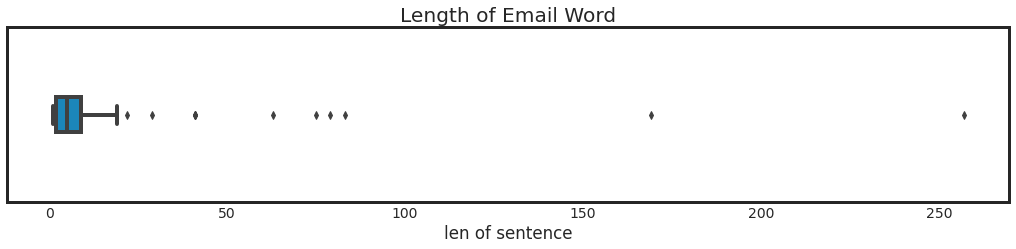

In [51]:
fig , ax = plt.subplots(1,1, figsize = (16,3))

sns.boxplot(data = df_nodepair1,
            x = 'len of sentence',
            width = 0.2)


plt.title('Length of Email Word');

In [52]:
cvec = CountVectorizer(ngram_range=(1,3))
cvec.fit(df_nodepair1['email'])
main = cvec.transform(df_nodepair1['email'])

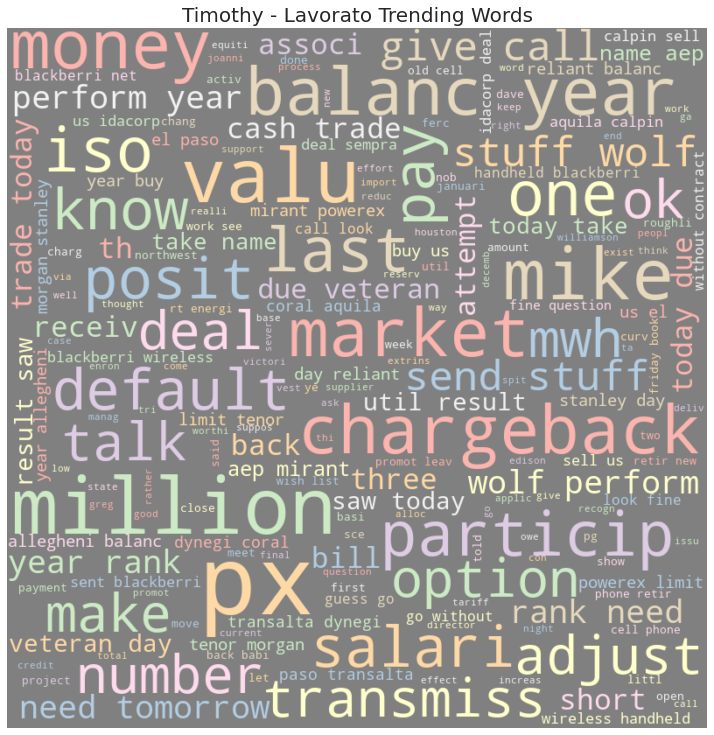

In [53]:
word_nodepair = ' '.join([word for word in df_nodepair1['email']])

wordcloud = WordCloud(width= 800, 
                       height= 800,
                       max_font_size = 110,
                       collocations = True,
                       background_color = 'grey',
                       colormap= 'Pastel1').generate(word_nodepair)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.title('Timothy - Lavorato Trending Words' , fontsize = 20);

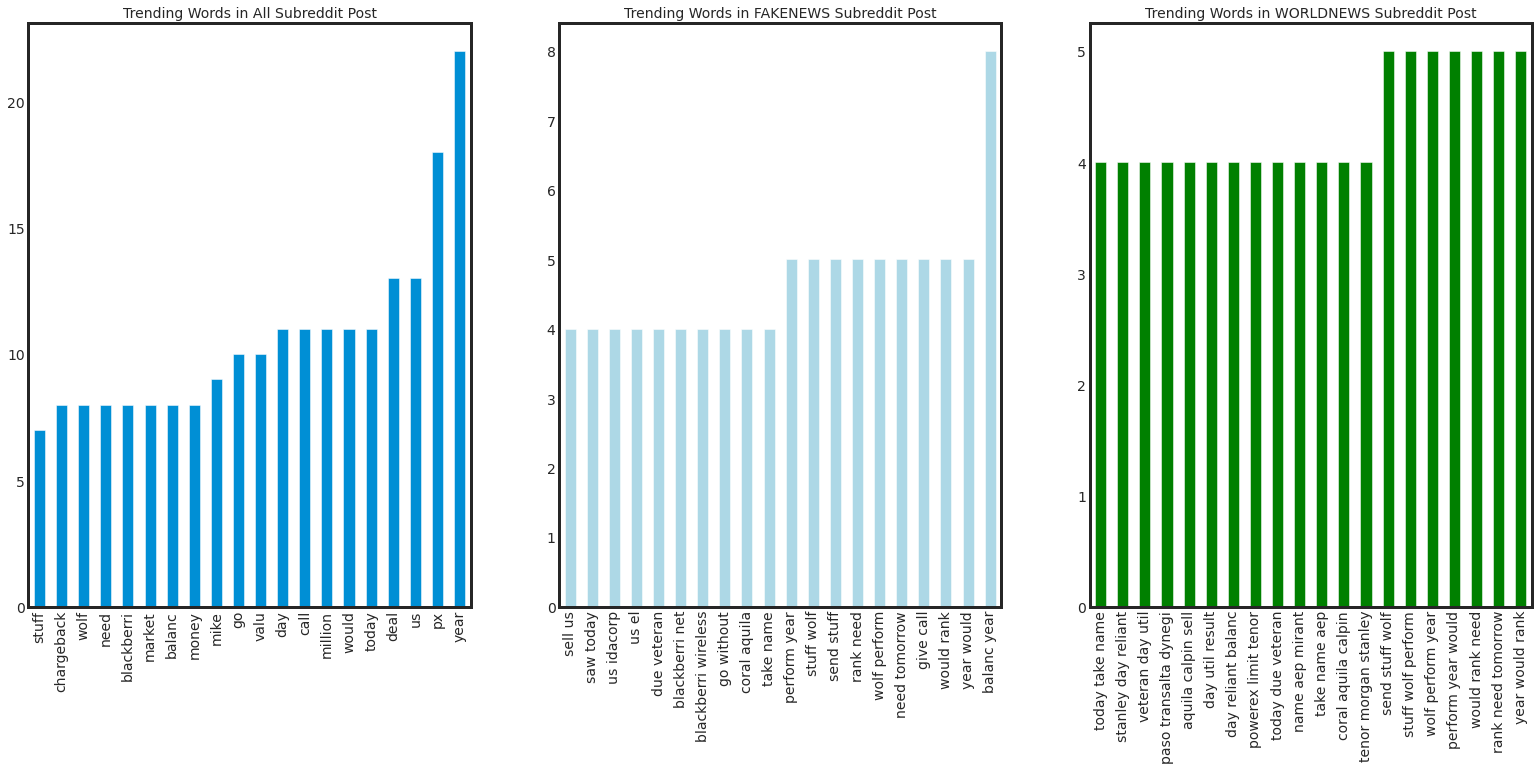

In [54]:
df_main_vocab_n1 = ngram_generator(df_nodepair1 , 1)
df_main_vocab_n2 = ngram_generator(df_nodepair1 , 2)
df_main_vocab_n3 = ngram_generator(df_nodepair1 , 3)

ngram_visualizer(df_main_vocab_n1 , df_main_vocab_n2 , df_main_vocab_n3)

### 4.4 Checking original email corresponding to popular word
___

- While we are able to zoom in further , but domain knowledge on this topics are further required to make more sense of the traced email , on whether there are attempts to cover up some wrong doing or nots.

In [55]:
df_nodepair1 = df_nodepair_main[filter_1 & filter_2]
df_nodepair1.loc[df_nodepair1['email'].str.contains('Wolfe')]

,send,receive,email
2032765,tim.belden@enron.com,john.lavorato@enron.com,Crandall done\nBadeer done\nSwerzbin submitted...
2032953,tim.belden@enron.com,john.lavorato@enron.com,I am making good progress. I have met with Mi...
2047120,tim.belden@enron.com,john.lavorato@enron.com,Done\nSwerzbin\nCrandall\nBadeer\n\nAlmost Don...
2065681,john.lavorato@enron.com,tim.belden@enron.com,Send me stuff on Wolfe's performance this year...
2068224,john.lavorato@enron.com,tim.belden@enron.com,Send me stuff on Wolfe's performance this year...
2077682,john.lavorato@enron.com,tim.belden@enron.com,Send me stuff on Wolfe's performance this year...
2083249,john.lavorato@enron.com,tim.belden@enron.com,"Tim,\n\nJohn is currently evaluating the curre..."
2083468,john.lavorato@enron.com,tim.belden@enron.com,Send me stuff on Wolfe's performance this year...
2085003,john.lavorato@enron.com,tim.belden@enron.com,Send me stuff on Wolfe's performance this year...
3587170,tim.belden@enron.com,john.lavorato@enron.com,We intend to reserve $5.5 million associated w...
